# A Glimpse of PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Load the CIFAR-10 dataset and define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


### Training Phase

In [17]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3600, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
net = SimpleCNN()
net.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the model
for epoch in range(5):  # Loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("Training finished!")

Epoch 1, Loss: 1.641421895872227
Epoch 2, Loss: 1.2879533700583001
Epoch 3, Loss: 1.1750398684753032
Epoch 4, Loss: 1.090450172079578
Epoch 5, Loss: 1.0183437143810574
Training finished!


### Evaluation Phase

In [3]:
def eval(model, testloader):
    # Testing the model
    correct = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")
            outputs = model(inputs)
            correct += sum(torch.argmax(outputs, dim=1)==labels).cpu().item()
    return correct

correct = eval(net, testloader)
print(f"Correctly predict {correct} of 10,000 (Acc: {correct/10000*100}%)")

Correctly predict 6082 of 10,000 (Acc: 60.81999999999999%)


### Inference Phase

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


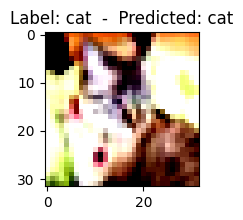

In [4]:
# Inference on a sample image
import matplotlib.pyplot as plt
import numpy as np

def predict(model, image):
    # Make predictions
    outputs = model(image.to("cuda").unsqueeze(dim=0))
    _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Define class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image, label = testset[8]

predicted = predict(net, image)

# Display the image and predicted class
imshow = np.transpose(image.numpy(), (1, 2, 0))

plt.figure(figsize = (2,2))
plt.imshow(imshow)
plt.title("Label: "+classes[label]+"  -  Predicted: "+str(classes[predicted]))
plt.show()

# Using A Pre-Trained Model

In [5]:
from resnet_cifar10 import *

net = resnet20()
net.to("cuda")

# load pretrained model
net.load_state_dict(torch.load("resnet20-0.pt"))

<All keys matched successfully>

### Evaluation Phase

In [6]:
# Testing the model
correct = eval(net, testloader)
print(f"Correctly predict {correct} of 10,000 (Acc: {correct/10000*100}%)")

Correctly predict 9172 of 10,000 (Acc: 91.72%)


# Introduction to PyTorch Hook

### Sample #1:
Let's print the input and output size for each layer.

Hook works like a "hook", you put an additional function to a tensor/module of a model. So, if you run the cell below twice, you will  put two functions in the tensor/module. If you want to reset it, you can reload the model (two cells above) or just keep reading

In [7]:
def hook(module, inp, out):
    with torch.no_grad():
        print("=======")
        print("module: ", module.__class__.__name__)
        print("input: ", inp[0].shape, " | output: ", out.shape)

for name, module in net.named_modules():
    if len(list(module.children()))==0: # if module is leaf (a layer)
        module.register_forward_hook(hook) # registering hook!!


image, label = testset[8]
predicted = predict(net, image)

module:  Conv2d
input:  torch.Size([1, 3, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  BatchNorm2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  Conv2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  BatchNorm2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  Conv2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  BatchNorm2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  Sequential
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  Conv2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  BatchNorm2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  Conv2d
input:  torch.Size([1, 16, 32, 32])  | output:  torch.Size([1, 16, 32, 32])
module:  BatchNorm2d
input:  torch.Size([1, 16, 32, 32]) 

The cell below will iterate all modules and print the registered forward hook. If there is a hook in it, it will print "hook".
Remember, a module is not the same with a layer. In previous cell, we only register hook to layers

In [8]:
def show_hooks(net):
    for name, module in net.named_modules():
        print(module.__class__.__name__, " : ", [ v.__name__ for _,v in module._forward_hooks.items()])

show_hooks(net)

ResNet  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Sequential  :  []
BasicBlock  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Sequential  :  ['hook']
BasicBlock  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Sequential  :  ['hook']
BasicBlock  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Sequential  :  ['hook']
Sequential  :  []
BasicBlock  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
LambdaLayer  :  ['hook']
BasicBlock  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Sequential  :  ['hook']
BasicBlock  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Sequential  :  ['hook']
Sequential  :  []
BasicBlock  :  []
Conv2d  :  ['hook']
BatchNorm2d  :  ['hook']
Conv2d  :  ['hook']
BatchNorm2d

Sadly, removing hook is not simple _(it's a hook! - pun intended)_.

No, actually is pretty simple. You can remove hook easily **if you keep the hook handle** when registering the hook:
```
handle = module.register_forward_hook(hook)
handle.remove() # hook deleted
```
but we didn't do it :( 

The other way is by restarting the Dict that store all the hooks in each model

In [9]:
from collections import OrderedDict
from typing import Dict, Callable

def clear_hooks(net):
    for name, module in net.named_modules():
        module._forward_hooks:Dict[int, Callable] = OrderedDict()

clear_hooks(net)
show_hooks(net)

ResNet  :  []
Conv2d  :  []
BatchNorm2d  :  []
Sequential  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
Sequential  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
Sequential  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
Sequential  :  []
Sequential  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
LambdaLayer  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
Sequential  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
Sequential  :  []
Sequential  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
LambdaLayer  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  []
Sequential  :  []
BasicBlock  :  []
Conv2d  :  []
BatchNorm2d  :  []
Conv2d  :  []
BatchNorm2d  :  

## Sample #2

In [10]:
from resnet_cifar10 import *

intermediate_outputs = []
net = resnet20()
net.to("cuda")

# load pretrained model
net.load_state_dict(torch.load("resnet20-0.pt"))

def hook(module, inp, out):
    with torch.no_grad():
        intermediate_outputs.append(out.detach())

for name, module in net.named_modules():
    if 'conv' in name:
        module.register_forward_hook(hook) # registering hook!!

image, label = testset[8]
predicted = predict(net, image)

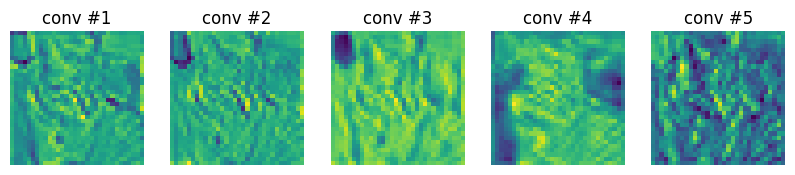

In [11]:
# visualize first 10 intermediate outputs in 2x5 grids
fig = plt.figure(figsize=(10, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(intermediate_outputs[i][0][0].cpu())
    ax.set_title(f"conv #{i+1}")
    ax.axis("off") 
plt.show()

# Triple Modular Redundancy

Create a layer-level TMR for a model

In [12]:
import copy 

class TMRmodel(nn.Module):
    
    def __init__(self, model):
        
        super(TMRmodel, self).__init__()
        self.model = copy.deepcopy(model)
        self.backup1 = nn.ParameterDict()
        self.backup2 = nn.ParameterDict()

        self.protected = False
        for name, module in self.model.named_modules():
            if len(list(module.children()))==0:
                module.__name__ = name
                with torch.no_grad():
                    self.backup1[name] = copy.deepcopy(module)
                    self.backup2[name] = copy.deepcopy(module)
                module.register_forward_hook(self.tmrhook())

    def tmrhook(self):
        def hook(module, inp, out_main):
            with torch.no_grad():
                if self.protected:
                    module_1 = self.backup1[module.__name__].eval()
                    module_2 = self.backup2[module.__name__].eval()
                    
                    out_backup_1 = module_1(inp[0])
                    out_backup_2 = module_2(inp[0])
                    
                    out_correct = None # correct output
                    flag = 0 # check error
                    if torch.allclose(out_main, out_backup_1, equal_nan=True):
                        if not torch.allclose(out_backup_1, out_backup_2, equal_nan=True):
                            flag += 2
                            out_correct = out_main
                    else:
                        flag += 1
                        out_correct = out_backup_1[:]
                        if not torch.allclose(out_backup_1, out_backup_2, equal_nan=True):
                            flag += 2
                            out_correct = out_main
                            if not torch.allclose(out_main, out_backup_2, equal_nan=True):
                                flag += 4

                    if flag==1: # error in main module
                        module = copy.deepcopy(module_1)
                    elif flag==3: # error in model_backup_1
                        module_1 = copy.deepcopy(module)
                    elif flag==2: # error in model_backup_2
                        module_2 = copy.deepcopy(module)
                    elif flag==7:
                        print("Error on more than or equal two modules")
                        
                    return out_correct 
        return hook

    def forward(self, x):
        out = self.model(x)
        return out

In [13]:
net = resnet20()
net.to("cuda")
net.load_state_dict(torch.load("resnet20-0.pt"))

tmrnet = TMRmodel(net)
tmrnet.to("cuda")

correct = eval(tmrnet, testloader)
print(f"Correctly predict {correct} of 10,000 (Acc: {correct/10000*100}%)")

Correctly predict 9172 of 10,000 (Acc: 91.72%)


In [14]:
with torch.no_grad():
    tmrnet.model.conv1.weight.copy_(torch.randn_like(net.conv1.weight))

In [15]:
correct = eval(tmrnet, testloader)
print(f"Correctly predict {correct} of 10,000 (Acc: {correct/10000*100}%)")

Correctly predict 2509 of 10,000 (Acc: 25.09%)


In [16]:
tmrnet.protected = True
correct = eval(tmrnet, testloader)
print(f"Correctly predict {correct} of 10,000 (Acc: {correct/10000*100}%)")

Correctly predict 9172 of 10,000 (Acc: 91.72%)
